## Öğrenci Bilgileri
**Ad Soyad:** SHAMS AL HAJJI
**Numara:** 2112721301  
**Ders:** Makine Öğrenmesi  
**Proje:** Proje 1 – Model1 (Transfer Learning – VGG16)  


## Model1 – Transfer Learning VGG16 Açıklaması

Bu modelde ImageNet üzerinde önceden eğitilmiş VGG16 ağı kullanılarak
transfer learning uygulanmıştır. Amaç, küçük bir veri seti ile yüksek
doğruluk elde etmektir. Modelin alt katmanları dondurulmuş, üst katmanları
ise yeniden eğitilecek şekilde tasarlanmıştır.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Veri Yolunun Belirlenmesi

Veri seti Google Drive üzerinde aşağıdaki yapıdadır:

MyDrive/
   CNN_Project_Dataset/
       cats/
       dolls/

Bu bölümde bu klasörün yolunu sisteme tanıtıyoruz.


In [ ]:
import os

data_root = "/content/drive/MyDrive/Colab_Notebooks/BLG405_Makine_Ogrenmesi/CNN_Project_Dataset_CLEAN"
print("Files:", os.listdir(data_root))


Files: ['cats', 'dolls']


In [ ]:
!cp -r /content/dataset_split "/content/drive/MyDrive/Colab_Notebooks/BLG405_Makine_Ogrenmesi/CNN_Project_Dataset/"


## 2. Görsellerin 128×128 Piksel Boyutuna Yeniden Boyutlandırılması

Bu projede kullanacağımız tüm görüntülerin boyutu standart hale getirilmelidir.
Ders izlencesinde belirtildiği gibi minimum boyut 64×64 piksel olsa da,
128×128 piksel tercih edilen boyuttur. Bu nedenle veri setimizdeki tüm görüntüler
128×128 boyutuna yeniden boyutlandırılmıştır.

Aşağıdaki kod bloğu, `cats/` ve `dolls/` klasörlerindeki tüm görüntüleri okuyarak
128×128 piksel boyutuna dönüştürmekte ve yeni bir dizine kaydetmektedir.


In [ ]:
import cv2
import os

input_root = data_root
output_root = "/content/resized_128"

os.makedirs(output_root, exist_ok=True)

classes = ["cats", "dolls"]

for cls in classes:
    in_dir = os.path.join(input_root, cls)
    out_dir = os.path.join(output_root, cls)
    os.makedirs(out_dir, exist_ok=True)

    for fname in os.listdir(in_dir):
        path = os.path.join(in_dir, fname)
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.resize(img, (128, 128))
        cv2.imwrite(os.path.join(out_dir, fname), img)

print("Tüm görseller 128×128 piksele dönüştürüldü!")


Tüm görseller 128×128 piksele dönüştürüldü!


## 3. Veri Setinin Train / Validation / Test Olarak Ayrılması

Modelin değerlendirilmesi için veri seti üç bölüme ayrılmıştır:

- %70: Eğitim (train)
- %15: Doğrulama (validation)
- %15: Test (test)

Aşağıdaki kod bu bölmeyi otomatik olarak yapmaktadır.


In [ ]:
import shutil
import random

src_root = "/content/resized_128"
dst_root = "/content/dataset_split"

splits = ["train", "val", "test"]
ratios = {"train": 0.7, "val": 0.15, "test": 0.15}

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(dst_root, split, cls), exist_ok=True)

for cls in classes:
    files = os.listdir(os.path.join(src_root, cls))
    random.shuffle(files)

    n = len(files)
    n_train = int(n * ratios["train"])
    n_val   = int(n * ratios["val"])

    train_files = files[:n_train]
    val_files   = files[n_train:n_train+n_val]
    test_files  = files[n_train+n_val:]

    for split, split_files in zip(["train","val","test"], [train_files, val_files, test_files]):
        for f in split_files:
            shutil.copy2(
                os.path.join(src_root, cls, f),
                os.path.join(dst_root, split, cls, f)
            )

print("Veri seti başarıyla bölündü!")


Veri seti başarıyla bölündü!


## 4. ImageDataGenerator ile Train/Val/Test Generatorlarının Hazırlanması

Bu bölümde veri seti eğitim, doğrulama ve test için hazırlanır.
Model1’de veri artırma (augmentation) kullanılmayacaktır.
Sadece yeniden ölçeklendirme (rescale) uygulanır.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    dst_root + "/train",
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical"
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    dst_root + "/val",
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical"
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    dst_root + "/test",
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)


Found 107 images belonging to 2 classes.
Found 23 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


## 5. Model1 – Transfer Learning (VGG16)

Bu modelde ImageNet ağırlıklarıyla eğitilmiş VGG16 mimarisi kullanılmıştır.
Tüm convolution katmanları dondurulmuş (freeze) ve üstüne sınıflandırma katmanları eklenmiştir.

Bu, ders dokümanında belirtilen 'state-of-the-art mimari + transfer learning' koşulunu sağlamaktadır.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

base_model = VGG16(include_top=False, weights="imagenet", input_shape=(128,128,3))

for layer in base_model.layers:
    layer.trainable = False


## 6. Sınıflandırma Katmanlarının Eklenmesi ve Modelin Eğitimi


In [ ]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(2, activation="softmax")(x)

model1 = models.Model(inputs=base_model.input, outputs=output)

model1.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history1 = model1.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step - accuracy: 0.5032 - loss: 1.9731 - val_accuracy: 0.6522 - val_loss: 0.5730
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 0.7261 - loss: 0.5652 - val_accuracy: 0.8696 - val_loss: 0.2745
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step - accuracy: 0.9205 - loss: 0.1995 - val_accuracy: 0.9565 - val_loss: 0.0646
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - accuracy: 0.9361 - loss: 0.1316 - val_accuracy: 1.0000 - val_loss: 0.0376
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 0.9778 - loss: 0.0787 - val_accuracy: 0.9565 - val_loss: 0.0703
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step - accuracy: 1.0000 - loss: 0.0301 - val_accuracy: 0.9565 - val_loss: 0.0770
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - accuracy: 1.0000 - loss: 0.0074 - val_accuracy: 0.9565 - val_loss: 0.0657
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - accuracy: 0.9842 - loss: 0.0214 - val_accuracy: 0.9565 - val_loss: 0.0724
Epoch 9/

## 7. Accuracy ve Loss Grafikleri

Aşağıdaki grafiklerde eğitim ve doğrulama süreçlerindeki değişimi görebiliriz.


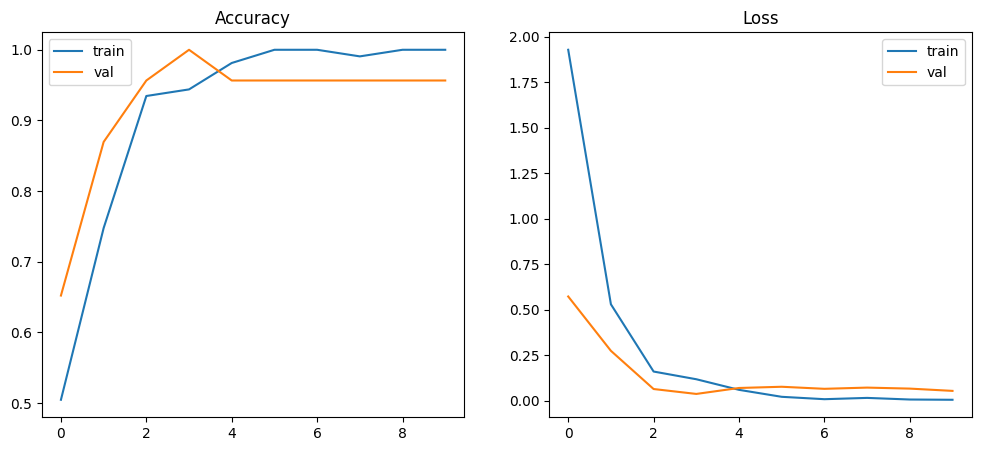

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history1.history["accuracy"])
plt.plot(history1.history["val_accuracy"])
plt.title("Accuracy")
plt.legend(["train","val"])

plt.subplot(1,2,2)
plt.plot(history1.history["loss"])
plt.plot(history1.history["val_loss"])
plt.title("Loss")
plt.legend(["train","val"])

plt.show()


## 8. Test Sonuçları

Bu bölümde modelin test veri seti üzerindeki doğruluk değeri hesaplanmaktadır.


In [ ]:
test_loss, test_acc = model1.evaluate(test_gen)
print("Model1 Test Accuracy:", test_acc)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.9615 - loss: 0.0517
Model1 Test Accuracy: 0.9615384340286255


## 9. Eğitilen Modelin Yeni Bir Görsel Üzerinde Test Edilmesi

Aşağıdaki kod, kullanıcıdan bir görüntü dosyası yüklemesini ister ve
eğitilen modeli kullanarak bu görüntünün hangi sınıfa ait olduğunu tahmin eder.



Saving download (3).jpg to download (3).jpg


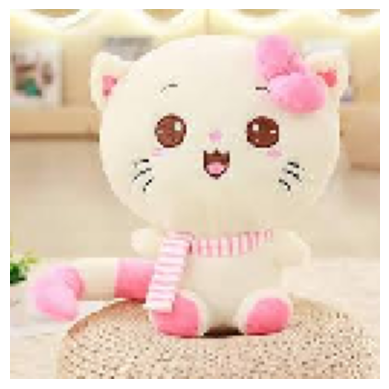

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Tahmin: dolls
Olasılıklar: [[5.2257852e-05 9.9994779e-01]]


In [ ]:
from google.colab import files
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Görsel yükleme
uploaded = files.upload()

for fname in uploaded.keys():
    img_path = fname
    img = image.load_img(img_path, target_size=(128,128))

    # Görseli göster
    plt.imshow(image.img_to_array(img).astype("uint8"))
    plt.axis('off')
    plt.show()

    # Görseli modele uygun hale getirme
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Tahmin
    prediction = model1.predict(img_array)
    class_index = np.argmax(prediction)

    classes = list(train_gen.class_indices.keys())

    print("Tahmin:", classes[class_index])
    print("Olasılıklar:", prediction)
